# Data description and summary

Dataset farm-ads memiliki **4143 observasi** dengan **78974 fitur**, berisi iklan-iklan (*ads*) yang diunggah di sebuah situs komunitas pertanian. Tujuan dari dataset ini adalah untuk mengembangkan model prediktif yang dapat secara otomatis mengklasifikasikan apakah sebuah iklan **relevan** (1) atau **tidak relevan** (−1) bagi komunitas tersebut. Informasi tambahan mengenai dataset farm-ads dari https://archive.ics.uci.edu/dataset/218/farm+ads di antaranya:
- Terdiri dari kata-kata yang ada di dalam iklan (*ad creative*) ditandai dengan awalan `ad-` dan halaman tujuan iklan (*landing page*).
- Tag HTML seperti *title* dan *header* dari *landing page* juga dicatat.
- Dataset yang ada **sudah melalui proses *stemming* dan penghapusan *stopword***.


# Objectives

1. Memprediksi relevansi iklan secara otomatis berdasarkan isi teksnya.
2. Mengidentifikasi topik-topik utama yang sering muncul dalam iklan di situs komunitas pertanian.

Analisis ini mengadaptasi penelitian dari **Royani dkk. (2023)** yang berhasil menerapkan LDA dan SVM untuk klasifikasi komentar positif/negatif pada platform *streaming*. Dalam konteks farm-ads, peran komentar digantikan oleh konten iklan, dan fokus klasifikasinya adalah relevansi terhadap komunitas pertanian.

# Methods
- ***Text classification*** menggunakan metode `SVM` dan *`Random Forest`*. Alasan dari metode SVM dipilih adalah karena pada penelitian sebelumnya (Royani, dkk., 2023), metode tersebut diketahui memiliki performa yang baik dalam melakukan klasifikasi komentar berdasarkan teks terutama pada dataset yang memiliki label. Metode *Random Forest* dipilih karena algoritmanya yang mudah dan dapat menangani data berdimensi tinggi (Syahputra, H., & Wibowo, A., 2023).
- ***Topic modeling*** menggunakan `LDA` dipilih karena LDA merupakan model generatif yang secara eksplisit memperlakukan distribusi topik dalam dokumen sebagai variabel acak tersembunyi (*hidden random variable*), bukan sebagai parameter yang tetap terkait langsung dengan dokumen pelatihan. Dengan pendekatan probabilistik ini, LDA tidak hanya mampu menggeneralisasi ke dokumen baru, tetapi juga menghindari pertumbuhan jumlah parameter yang berlebihan sehingga lebih tahan terhadap *overfitting* (Blei, D. M., Ng, A. Y., & Jordan, M. I., 2003).


# Import libraries & load dataset

In [1]:
!pip install numpy==1.24.4
!pip install dmba scikit-learn gensim matplotlib
!pip install pyLDAvis==3.4.1

In [2]:
# Import libraries
import pandas as pd
import re
from dmba import load_data
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models

import logging
import warnings

Colab environment detected.


In [3]:
# Load data
data = load_data('farm-ads.csv', names=["label", "text"])
data

,label,text
0,-1,ad-abdominal ad-aortic ad-aneurysm ad-doctorf...
1,-1,ad-abdominal ad-aortic ad-aneurysm ad-million...
2,-1,ad-absorbent ad-oil ad-snar ad-factory ad-dir...
3,-1,ad-acid ad-reflux ad-relief ad-top ad-treatme...
4,-1,ad-acid ad-reflux ad-symptom ad-acid ad-reflu...
...,...,...
4138,1,ad-zupreem ad-pet ad-food ad-price ad-guarant...
4139,1,ad-zupreem ad-pet ad-food ad-zupreem ad-anima...
4140,1,ad-zupreem ad-pet ad-food ad-zupreem ad-anima...
4141,1,ad-zupreem ad-pet ad-food ad-zupreem ad-anima...


# Preprocessing

- *Prefixes removal* untuk menghilangkan awalan (ad-, title-, header-, dll.)
- Tokenisasi untuk memecah sebuah teks atau kalimat menjadi bagian-bagian kecil (token)
- Mengubah teks menjadi angka menggunakan pendekatan TF-IDF dengan memanfaatkan pustaka `TfidfVectorizer` Scikit-learn

https://www.kaggle.com/code/arthurtok/spooky-nlp-and-topic-modelling-tutorial




In [4]:
# Remove prefixes (as per farm-ads structure)
def remove_prefixes(text):
    return re.sub(r'\b(?:ad|title|header|page|file|com|org|net|aaa|www)-', '', text)

data['clean_text'] = data['text'].apply(remove_prefixes)

In [5]:
# Tokenization (data sudah bersih dari stopwords & sudah di-stemming)
data['tokens'] = data['clean_text'].str.split()

In [6]:
# Dictionary & corpus
dictionary = corpora.Dictionary(data['tokens'])
corpus = [dictionary.doc2bow(text) for text in data['tokens']]

Menurut Royani et al. (2023), untuk melakukan *topic modeling*, data diubah dalam bentuk *dictionary* dan *corpus*. *Dictionary* merupakan format data yang mengandung himpunan perwakilan kata yang diberi indeks sehingga dapat memudahkan dalam menampilkan kata yang termasuk dalam model. *Corpus* merupakan format data yang berbentuk dokumen term matrix yang digunakan dalam melakukan pembentukan model. *Dictionary* dan *corpus* adalah dua input untuk *topic modelling* LDA yang dibuat menggunakan modul `gensim corpora`.

In [7]:
# Feature Extraction
vectorizer = CountVectorizer(analyzer=lambda x: x)
X_counts = vectorizer.fit_transform(corpus)

transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X_counts)
y = data['label']

# Ambil nama-nama fitur (kata-kata)
feature_names = vectorizer.get_feature_names_out()

# Konversi ke DataFrame agar mudah dibaca
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)
print(df_tfidf)

        (0, 1)  (0, 2)  (0, 18)    (1, 1)  (1, 2)  (1, 3)  (1, 4)  (1, 7)  \
0     0.341604     0.0      0.0  0.235040     0.0     0.0     0.0     0.0   
1     0.326771     0.0      0.0  0.224835     0.0     0.0     0.0     0.0   
2     0.000000     0.0      0.0  0.000000     0.0     0.0     0.0     0.0   
3     0.000000     0.0      0.0  0.000000     0.0     0.0     0.0     0.0   
4     0.000000     0.0      0.0  0.000000     0.0     0.0     0.0     0.0   
...        ...     ...      ...       ...     ...     ...     ...     ...   
4138  0.000000     0.0      0.0  0.000000     0.0     0.0     0.0     0.0   
4139  0.000000     0.0      0.0  0.000000     0.0     0.0     0.0     0.0   
4140  0.000000     0.0      0.0  0.000000     0.0     0.0     0.0     0.0   
4141  0.000000     0.0      0.0  0.000000     0.0     0.0     0.0     0.0   
4142  0.000000     0.0      0.0  0.000000     0.0     0.0     0.0     0.0   

        (2, 1)  (2, 3)  ...  (47533, 1)  (47534, 1)  (47535, 1)  (47536, 1)

# Text Classification

In [8]:
# Cek distribusi variabel target
data['label'].value_counts()

,count
label,
1,2210
-1,1933


In [9]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## SVM

In [ ]:
# Menentukan hyperparameter
parameters_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [1, 5, 10, 20],
    'gamma': ['scale', 'auto']  # untuk kernel rbf
}

# Inisialisasi model
svm = SVC(random_state=42)

# Hyperparameter
classifier_svm = GridSearchCV(svm, parameters_svm, cv=5)

# Melatih model
classifier_svm.fit(X_train, y_train)
classifier_svm.cv_results_

# Hyperparameter terbaik
best_parameters_svm = classifier_svm.best_params_
print("Best Parameters:", best_parameters_svm)

# Menggunakan hyperparameter terbaik untuk melatih model
best_svm = classifier_svm.best_estimator_

# Memprediksi data uji
y_pred_svm = best_svm.predict(X_test)

# Menampilkan classification report
print(classification_report(y_test, y_pred_svm))

Best Parameters: {'C': 5, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.92      0.90      0.91       387
           1       0.92      0.93      0.92       442

    accuracy                           0.92       829
   macro avg       0.92      0.92      0.92       829
weighted avg       0.92      0.92      0.92       829



## Random Forest

In [ ]:
# Menentukan hyperparameter
parameters_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Inisialisasi model
rf = RandomForestClassifier(random_state=42)

# Hyperparameter
classifier_rf = GridSearchCV(rf, parameters_rf, cv=5)

# Melatih model
classifier_rf.fit(X_train, y_train)
classifier_rf.cv_results_

# Hyperparameter terbaik
best_parameters_rf = classifier_rf.best_params_
print("Best Parameters:", best_parameters_rf)

# Menggunakan hyperparameter terbaik untuk melatih model
best_rf = classifier_rf.best_estimator_

# Memprediksi data uji
y_pred_rf = best_rf.predict(X_test)

# Menampilkan classification report
print(classification_report(y_test, y_pred_rf))

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
              precision    recall  f1-score   support

          -1       0.90      0.91      0.90       387
           1       0.92      0.91      0.91       442

    accuracy                           0.91       829
   macro avg       0.91      0.91      0.91       829
weighted avg       0.91      0.91      0.91       829



# Topic Modelling [campur]

In [10]:
# Menentukan Jumlah Topik Optimal (Coherence Score dengan Gensim)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=42,
                                       passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary, corpus, data['tokens'], start=2, limit=10, step=1)

Berdasarkan Royani et al. (2023), untuk menentukan jumlah topik atau `num topics` dengan menggunakan modul `gensim coherencemodel` dapat divisualisasikan dalam bentuk **grafik *coherence score***. *Coherence score* adalah ukuran untuk menentukan jumlah topik dengan **nilai tertinggi** yang akan diambil.

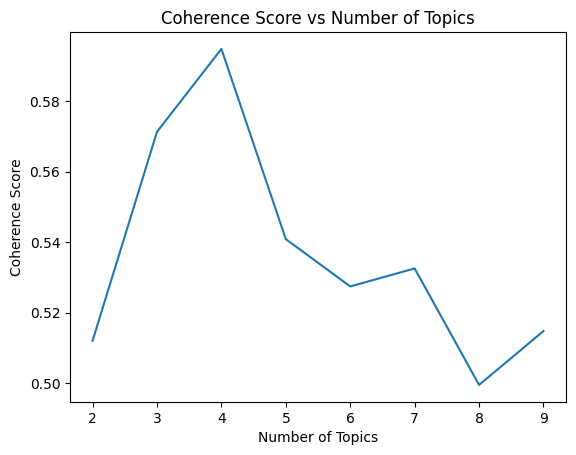

In [11]:
# Visualisasi Coherence Score:
x = range(2, 10)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

Berdasarkan grafik *coherence score*, nilai tertinggi sebesar ~0,60 dicapai pada topik ke-4, sehingga dipilih 4 topik sebagai jumlah topik optimal dalam model LDA.

In [13]:
# Topic Modeling with LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=4, random_state=42, passes=10)

In [14]:
# Visualisasi Topic
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_vis.html')  # Simpan ke file HTML

Menurut Maarif, M. R. (2022), untuk menyelidiki dan memvalidasi apakah jumlah klaster yang telah ditentukan sudah optimal, dilakukan visualisasi klaster menggunakan *inter-topic distance map*. Untuk melakukan tugas ini, digunakan pustaka `gensim`. Suatu klaster dianggap baik jika **terpisah dengan jelas satu sama lain**.

*Inter-topic distance map* menunjukkan bahwa topik 1 dan 2 saling tumpang tindih, menandakan keduanya memiliki tema serupa/berkaitan. Topik 3 dan 4 berada cukup jauh dari topik lainnya, menandakan mereka memiliki tema yang berbeda. Topik 1 dan 2 paling dominan dalam seluruh korpus (memiliki ukuran lingkaran lebih besar).

*Topic modelling* dapat menemukan nilai kata terhadap topik dan topik terhadap dokumen. Adapun hasil dari topik terhadap kata pada *output* di bawah ini.

In [ ]:
# Show topics
for idx, topic in lda_model.print_topics(num_topics=4, num_words=10):
    print(f"\nTopik {idx+1}:")
    print(topic)


Topik 1:
0.013*"list" + 0.012*"com" + 0.011*"product" + 0.007*"rabbit" + 0.006*"home" + 0.006*"save" + 0.006*"price" + 0.005*"free" + 0.005*"ad" + 0.005*"goat"

Topik 2:
0.060*"dog" + 0.060*"aquarium" + 0.048*"food" + 0.035*"reptile" + 0.035*"cat" + 0.026*"pet" + 0.023*"pond" + 0.021*"filter" + 0.021*"bird" + 0.012*"treat"

Topik 3:
0.008*"health" + 0.008*"diet" + 0.008*"weight" + 0.007*"product" + 0.006*"disease" + 0.006*"thyroid" + 0.005*"vitamin" + 0.005*"treatment" + 0.005*"help" + 0.005*"week"

Topik 4:
0.048*"law" + 0.025*"uk" + 0.022*"veterinary" + 0.019*"justanswer" + 0.016*"question" + 0.016*"answer" + 0.015*"dr" + 0.014*"veterinarian" + 0.012*"com" + 0.011*"car"


Nilai seperti 0.013, 0.060, dan seterusnya yang muncul dalam daftar kata tiap topik dari model LDA adalah bobot probabilitas (*weight atau probability score*) dari setiap kata terhadap topik tersebut. **Nilai ini menjelaskan seberapa besar kontribusi atau pentingnya kata itu dalam mendeskripsikan topik**. Misalnya:
```
Topik 1:
0.013*"list" + 0.012*"com" + 0.011*"product" + ...
```
0.013*"list" berarti: kata "list" memiliki bobot 0.013 dalam Topik 1. Artinya sekitar 1.3% dari isi Topik 1 dijelaskan oleh kata "list".

---

Dalam LDA, makna topik bukan hanya dari satu kata dengan bobot tertinggi, tapi kombinasi kata-kata dominan (Maarif, M. R., 2022). Dapat diketahui bahwa masing-masing topik memiliki kata-kata dominan yang mencerminkan tema tertentu. Misalnya, **Topik 1** memuat kata list, product, rabbit, home, dan price, yang mengarah pada topik seputar **produk rumah dan hewan**. **Topik 2** berisi kata seperti dog, aquarium, cat, dan pet yang menunjukkan tema **hewan peliharaan**. **Topik 3** mencakup kata seperti health, diet, disease, dan vitamin, mengarah pada **kesehatan dan nutrisi**. Sedangkan **Topik 4** menekankan kata seperti law, uk, dan veterinary, yang mengindikasikan tema **hukum dan konsultasi veteriner (kesehatan hewan)**.


*Topic modelling* LDA menghasilkan nilai topik terhadap dokumen. Nilai topik terhadap dokumen tersebut dapat menentukan aspek yang mewakili sebuah iklan pada komunitas pertanian. Adapun hasil dari topik terhadap dokumen pada *output* di bawah ini.

In [ ]:
# Distribusi topik untuk setiap dokumen
doc_topic_dist = []
for bow in corpus:
    topic_probs = lda_model.get_document_topics(bow, minimum_probability=0)
    topic_probs = [prob for _, prob in topic_probs]
    doc_topic_dist.append(topic_probs)

# Masukkan ke DataFrame
topic_columns = [f"Topik {i+1}" for i in range(lda_model.num_topics)]
doc_topic_df = pd.DataFrame(doc_topic_dist, columns=topic_columns)
doc_topic_df.insert(0, "Kalimat", data["clean_text"])

# Tampilkan
doc_topic_df.head()

,Kalimat,Topik 1,Topik 2,Topik 3,Topik 4
0,abdominal aortic aneurysm doctorfinder help p...,0.018648,0.017234,0.947840,0.016278
1,abdominal aortic aneurysm million american li...,0.506562,0.013306,0.466726,0.013406
2,absorbent oil snar factory direct pric truckl...,0.989839,0.003293,0.003252,0.003616
3,acid reflux relief top treatment option solut...,0.012423,0.012076,0.963186,0.012315
4,acid reflux symptom acid reflux symptom info ...,0.249754,0.010952,0.727532,0.011762


Interpretasi:
- **Dokumen  0**:
  - Probabilitas tertinggi: Topik 3 = 0.947840
  - Interpretasi: Kalimat ini kemungkinan besar berkaitan dengan topik 3 karena probabilitasnya paling tinggi dibandingkan topik lainnya. Maka, topik utama kalimat ini adalah topik ke-3 yaitu **kesehatan & nutrisi**
- **Dokumen  1**:
  - Probabilitas tertinggi: Topik 1 = 0.506562
  - Interpretasi: Kalimat ini kemungkinan besar berkaitan dengan topik 1 karena probabilitasnya paling tinggi dibandingkan topik lainnya. Maka, topik utama kalimat ini adalah topik ke-1 yaitu **produk rumah dan hewan**
- **Dokumen  2**:
  - Probabilitas tertinggi: Topik 1 = 0.989839
  - Interpretasi: Kalimat ini kemungkinan besar berkaitan dengan topik 1 karena probabilitasnya paling tinggi dibandingkan topik lainnya. Maka, topik utama kalimat ini adalah topik ke-1 yaitu **produk rumah dan hewan**

  dst.

# Topic Modelling [pisah]

In [ ]:
# Pisahkan data berdasarkan label
data_relevan = data[data['label'] == 1].copy()
data_non = data[data['label'] == -1].copy()

In [ ]:
# Tokenisasi
data_relevan['tokens'] = data_relevan['clean_text'].str.split()
data_non['tokens'] = data_non['clean_text'].str.split()

In [ ]:
# Sembunyikan warning dari gensim
logging.getLogger("gensim.models.ldamodel").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Fungsi untuk Coherence Score
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=42,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Fungsi untuk Topic Modelling
def topic_modeling_by_label(data_subset, label_name, start=2, limit=10, step=1):
    print(f"\n=========== Topic Modelling untuk Label {label_name.upper()} ===========")

    # Dictionary dan Corpus
    dictionary = corpora.Dictionary(data_subset['tokens'])
    corpus = [dictionary.doc2bow(text) for text in data_subset['tokens']]

    # Cari coherence score untuk berbagai jumlah topik
    model_list, coherence_values = compute_coherence_values(dictionary, corpus, data_subset['tokens'],
                                                            start=start, limit=limit, step=step)

    # Visualisasi coherence score
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title(f"Coherence Score vs Number of Topics ({label_name})")
    plt.show()

    # Cari model dengan coherence terbaik
    best_index = coherence_values.index(max(coherence_values))
    best_model = model_list[best_index]
    best_num_topics = x[best_index]
    print(f"\n>> Jumlah topik optimal untuk '{label_name}': {best_num_topics} (Coherence: {max(coherence_values):.4f})")

    # Visualisasi dengan pyLDAvis
    vis = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
    pyLDAvis.save_html(vis, f'lda_vis_{label_name}.html')

    # Tampilkan topik
    for idx, topic in best_model.print_topics(num_topics=best_num_topics, num_words=10):
        print(f"\nTopik {idx+1} ({label_name}):\n{topic}")

    # Distribusi topik per dokumen
    doc_topic_dist = []
    for bow in corpus:
        topic_probs = best_model.get_document_topics(bow, minimum_probability=0)
        topic_probs = [prob for _, prob in topic_probs]
        doc_topic_dist.append(topic_probs)

    # Masukkan ke DataFrame
    topic_columns = [f"Topik {i+1}" for i in range(best_num_topics)]
    doc_topic_df = pd.DataFrame(doc_topic_dist, columns=topic_columns)
    doc_topic_df.insert(0, "Kalimat", data_subset["clean_text"].values)

    # Bulatkan angka
    doc_topic_df.iloc[:, 1:] = doc_topic_df.iloc[:, 1:].astype(float).round(4)

    display(doc_topic_df.head())

    return best_model, doc_topic_df


=========== Topic Modelling untuk Label RELEVAN ===========


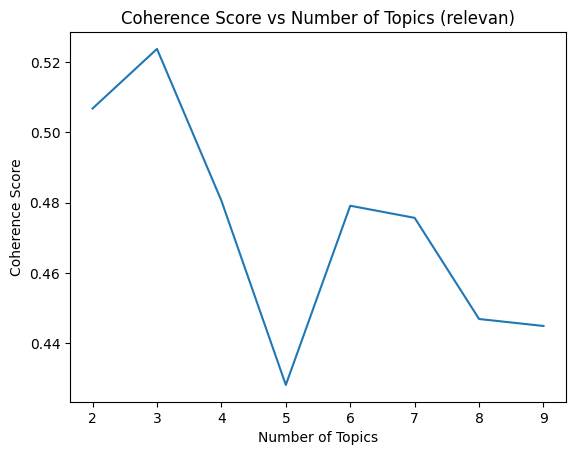


>> Jumlah topik optimal untuk 'relevan': 3 (Coherence: 0.5238)

Topik 1 (relevan):
0.041*"law" + 0.021*"uk" + 0.019*"veterinary" + 0.017*"dog" + 0.016*"justanswer" + 0.014*"question" + 0.013*"answer" + 0.013*"dr" + 0.013*"cat" + 0.012*"pet"

Topik 2 (relevan):
0.009*"diet" + 0.009*"weight" + 0.008*"product" + 0.008*"health" + 0.007*"food" + 0.006*"dog" + 0.005*"vitamin" + 0.005*"recipe" + 0.005*"thyroid" + 0.005*"loss"

Topik 3 (relevan):
0.014*"list" + 0.013*"com" + 0.011*"product" + 0.008*"rabbit" + 0.007*"pet" + 0.007*"save" + 0.006*"free" + 0.005*"farm" + 0.005*"price" + 0.005*"ad"


,Kalimat,Topik 1,Topik 2,Topik 3
0,abdominal aortic aneurysm million american li...,0.0003,0.1362,0.8635
1,ac montana ranch horse cattle ranch beautiful...,0.0004,0.0003,0.9993
2,acai pure product amazon acai acai berry acai...,0.0000,0.7703,0.2296
3,acclaim website builder design create own web...,0.0002,0.0001,0.9997
4,acclaim website builder design create own web...,0.0002,0.0001,0.9997



=========== Topic Modelling untuk Label NON_RELEVAN ===========


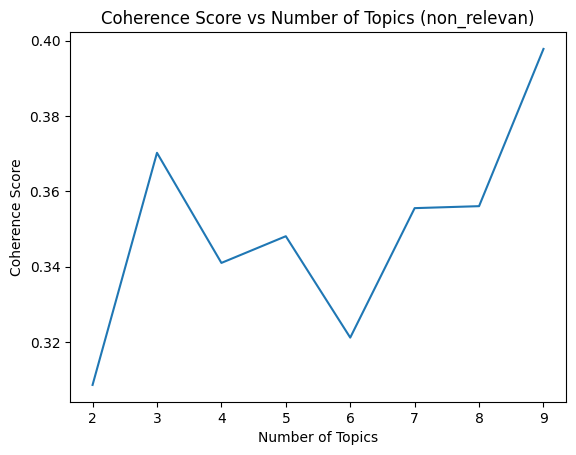


>> Jumlah topik optimal untuk 'non_relevan': 9 (Coherence: 0.3978)

Topik 1 (non_relevan):
0.048*"dentist" + 0.023*"dental" + 0.019*"disease" + 0.016*"treatment" + 0.015*"gum" + 0.010*"teeth" + 0.009*"home" + 0.008*"read" + 0.008*"periodontal" + 0.007*"teen"

Topik 2 (non_relevan):
0.016*"land" + 0.015*"home" + 0.014*"county" + 0.011*"colon" + 0.011*"colitis" + 0.008*"ulcerative" + 0.008*"lake" + 0.006*"realty" + 0.005*"patient" + 0.005*"people"

Topik 3 (non_relevan):
0.034*"week" + 0.021*"baby" + 0.019*"water" + 0.018*"treatment" + 0.013*"pregnancy" + 0.013*"birth" + 0.010*"labor" + 0.010*"pregnant" + 0.009*"chime" + 0.009*"ivf"

Topik 4 (non_relevan):
0.009*"report" + 0.008*"abuse" + 0.008*"wrote" + 0.007*"am" + 0.007*"thyroid" + 0.007*"boy" + 0.006*"baby" + 0.006*"girl" + 0.006*"pm" + 0.006*"test"

Topik 5 (non_relevan):
0.024*"price" + 0.013*"rabbit" + 0.013*"volkswagen" + 0.012*"fair" + 0.010*"eye" + 0.010*"product" + 0.010*"com" + 0.008*"siemen" + 0.008*"review" + 0.007*"sale"


,Kalimat,Topik 1,Topik 2,Topik 3,Topik 4,Topik 5,Topik 6,Topik 7,Topik 8,Topik 9
0,abdominal aortic aneurysm doctorfinder help p...,0.0029,0.0030,0.1969,0.0029,0.0033,0.7798,0.0036,0.0044,0.0033
1,abdominal aortic aneurysm million american li...,0.0024,0.0025,0.0030,0.0024,0.0027,0.6507,0.3298,0.0037,0.0027
2,absorbent oil snar factory direct pric truckl...,0.0005,0.0005,0.0006,0.0005,0.0778,0.9181,0.0006,0.0008,0.0006
3,acid reflux relief top treatment option solut...,0.0022,0.0022,0.0027,0.0022,0.1142,0.0026,0.0027,0.0033,0.8679
4,acid reflux symptom acid reflux symptom info ...,0.0020,0.0020,0.0024,0.0020,0.1882,0.0024,0.0025,0.0030,0.7954


In [ ]:
# Jalankan Topic Modelling untuk Masing-Masing Label
lda_relevan, df_relevan = topic_modeling_by_label(data_relevan, 'relevan')
lda_non, df_non = topic_modeling_by_label(data_non, 'non_relevan')

Interpretasi:
- Berdasarkan grafik *coherence score*, nilai tertinggi di kelas relevan sebesar ~0,525 dicapai pada topik ke-3 dan nilai tertinggi di kelas tidak relevan sebesar ~0,40 dicapai pada topik ke-9 sehingga dipilih 3 topik sebagai jumlah topik optimal kelas relevan dan 9 topik sebagai jumlah topik optimal kelas tidak relevan dalam model LDA.
- *Inter-topic distance map* menunjukkan bahwa pada kelas relevan, ketiga topik  cukup berjauhan, menandakan ketiganya memiliki tema yang berbeda dengan topik 1 dominan dalam seluruh korpus. Sedangkan pada kelas tidak relevan, topik 4 dan 5 serta topik 1, 3, 6 masih saling tumpang tindih, menandakan mereka memiliki tema serupa/berkaitan. *Topic modeling* per kelas lebih baik dibandingkan *topic modeling* secara keseluruhan karena hasil pemodelan di kelas relevan menunjukkan kualitas klaster yang baik.
- Adapun hasil dari topik terhadap kata di antaranya:
  - Relevan:
    - Topik 1 (law, uk, veterinary, dog, cat, pet, dll.): hukum dan konsultasi veteriner
    - Topik 2 (diet, product, health, food, dog, dll.): kesehatan dan nutrisi hewan
    - Topik 3 (list, com, product, rabbit, pet, farm, price, dll.): produk hewan
  - Tidak relevan:
    - Topik 1 (dentist, dental, disease, treatment, dll.): perawatan dan penyakit gigi
    - Topik 2 (land, home, county, colon, colitis, dll.): properti dan penyakit usus
    - Topik 3 (week, baby, baby, pregnancy, labor, dll.): kehamilan dan persalinan
    - Topik 4 (report, abuse, wrote, boy, girl, dll.): laporan kasus pelecehan
    - Topik 5 (price, rabbit, volkswagen, review, dll.): harga dan ulasan produk
    - Topik 6 (health, site, donor, egg, ivf, dll.): donor dan informasi kesehatan
    - Topik 7 (list, product, com, save, image, dll.): listing produk dan iklan digital
    - Topik 8 (pain, disease, disc, treatment, arthritis, dll.): nyeri dan penyakit sendi
    - Topik 9 (disease, crohn, cause, symptom, colitis, dll.): penyakit radang usus

In [ ]:
# Tampilkan hasilnya
print("\nHasil Topic Modeling untuk Kalimat Relevan:")
print(df_relevan.head())

print("\nHasil Topic Modeling untuk Kalimat Non-Relevan:")
print(df_non.head())


Hasil Topic Modeling untuk Kalimat Relevan:
                                             Kalimat  Topik 1  Topik 2  \
0   abdominal aortic aneurysm million american li...   0.0003   0.1362   
1   ac montana ranch horse cattle ranch beautiful...   0.0004   0.0003   
2   acai pure product amazon acai acai berry acai...   0.0000   0.7703   
3   acclaim website builder design create own web...   0.0002   0.0001   
4   acclaim website builder design create own web...   0.0002   0.0001   

   Topik 3  
0   0.8635  
1   0.9993  
2   0.2296  
3   0.9997  
4   0.9997  

Hasil Topic Modeling untuk Kalimat Non-Relevan:
                                             Kalimat  Topik 1  Topik 2  \
0   abdominal aortic aneurysm doctorfinder help p...   0.0029   0.0030   
1   abdominal aortic aneurysm million american li...   0.0024   0.0025   
2   absorbent oil snar factory direct pric truckl...   0.0005   0.0005   
3   acid reflux relief top treatment option solut...   0.0022   0.0022   
4   acid refl

Interpretasi:
- Relevan:
  - **Dokumen  0**:
    - Probabilitas tertinggi: Topik 3 = 0.8635
    - Interpretasi: Kalimat ini kemungkinan besar berkaitan dengan topik 3 karena probabilitasnya paling tinggi dibandingkan topik lainnya. Maka, topik utama kalimat ini adalah topik ke-3 yaitu **produk hewan**
  - **Dokumen  1**:
    - Probabilitas tertinggi: Topik 3 = 0.9993
    - Interpretasi: Kalimat ini kemungkinan besar berkaitan dengan topik 3 karena probabilitasnya paling tinggi dibandingkan topik lainnya. Maka, topik utama kalimat ini adalah topik ke-3 yaitu **produk hewan**

  dst.
- Tidak relevan:
  - **Dokumen  0**:
    - Probabilitas tertinggi: Topik 6 = 0.7798
    - Interpretasi: Kalimat ini kemungkinan besar berkaitan dengan topik 3 karena probabilitasnya paling tinggi dibandingkan topik lainnya. Maka, topik utama kalimat ini adalah topik ke-3 yaitu **donor dan informasi kesehatan**
  - **Dokumen  1**:
    - Probabilitas tertinggi: Topik 6 = 0.6507
    - Interpretasi: Kalimat ini kemungkinan besar berkaitan dengan topik 6 karena probabilitasnya paling tinggi dibandingkan topik lainnya. Maka, topik utama kalimat ini adalah topik ke-6 yaitu **donor dan informasi kesehatan**

  dst.

# Daftar Pustaka
- Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. Journal of Machine Learning Research, 3, 993–1022. http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf
- Maarif, M. R. (2022). Summarizing online customer review using topic modeling and sentiment analysis. JISKA (Jurnal Informatika Sunan Kalijaga), 7(3), 177–191. Retrieved from https://ejournal.uin-suka.ac.id/saintek/jiska/
- Mesterharm, C., & Pazzani, M. (2011). Farm Ads Data Set. UCI Machine Learning Repository. https://doi.org/10.24432/C5ZC8D
- Royani, N., Widodo, C. E., & Warsito, B. (2023). Topic modelling latent Dirichlet allocation untuk klasifikasi komentar pada layanan streaming platform. Jurnal Sains dan Teknologi, 12(3), 815–822. https://doi.org/10.23887/jstundiksha.v12i3.68492
- scikit-learn developers. (n.d.). sklearn.model_selection.GridSearchCV - scikit-learn 1.4.2 documentation. Diakses pada 19 Mei 2025, dari https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- Santosa, B. D., Fatimah, N., Kusumaningtyas, N. I., Aesyi, U. S., & Santoso, H. (2023). Analisis kepercayaan masyarakat tentang kepolisian Indonesia di Twitter menggunakan Latent Dirichlet Allocation (LDA). Indonesian Journal on Data Science, 1(2), 66–76.
- Syahputra, H., & Wibowo, A. (2023). Comparison of Support Vector Machine (SVM) and Random Forest Algorithm for Detection of Negative Content on Websites. Jurnal Ilmiah Teknik Elektro Komputer dan Informatika (JITEKI), 9(1), 165–173. https://doi.org/10.26555/jiteki.v9i1.25861